In [9]:
from river import datasets, metrics, stream, evaluate
from IncrementalTorch.classification import PyTorch2RiverClassifier
from IncrementalTorch.classification.nn_builder import build_torch_mlp_classifier
import torch
from sklearn.datasets import fetch_covtype
from tqdm import tqdm
import matplotlib.pyplot as plt

In [19]:
dataset = stream.iter_sklearn_dataset(fetch_covtype())
track = evaluate.Track('Covertype', dataset, metrics.Accuracy(), n_samples=5000)

def build_fn(n_features, n_classes=1):
    net = torch.nn.Sequential(
        torch.nn.Linear(n_features, 5),
        torch.nn.ReLU(),
        torch.nn.Linear(5, 5),
        torch.nn.ReLU(),
        torch.nn.Linear(5, n_classes),
    )
    return net

optimizer_fn = torch.optim.SGD
model = PyTorch2RiverClassifier(build_fn=build_fn,loss_fn="ce",optimizer_fn=optimizer_fn)

In [ ]:
step = []
error = []
r_time = []
memory = []

for checkpoint in tqdm(track.run(model, n_checkpoints=100)):
    step.append(checkpoint["Step"])
    error.append(checkpoint['Accuracy'])
    r_time.append(checkpoint["Time"].total_seconds())
    raw_memory, unit = float(checkpoint["Memory"][:-3]), checkpoint["Memory"][-2:]
    memory.append(raw_memory * 2**-10 if unit == 'KB' else raw_memory)

85it [00:18, 189.06it/s]

Text(0.5, 0, 'Instances')

<Figure size 432x288 with 0 Axes>

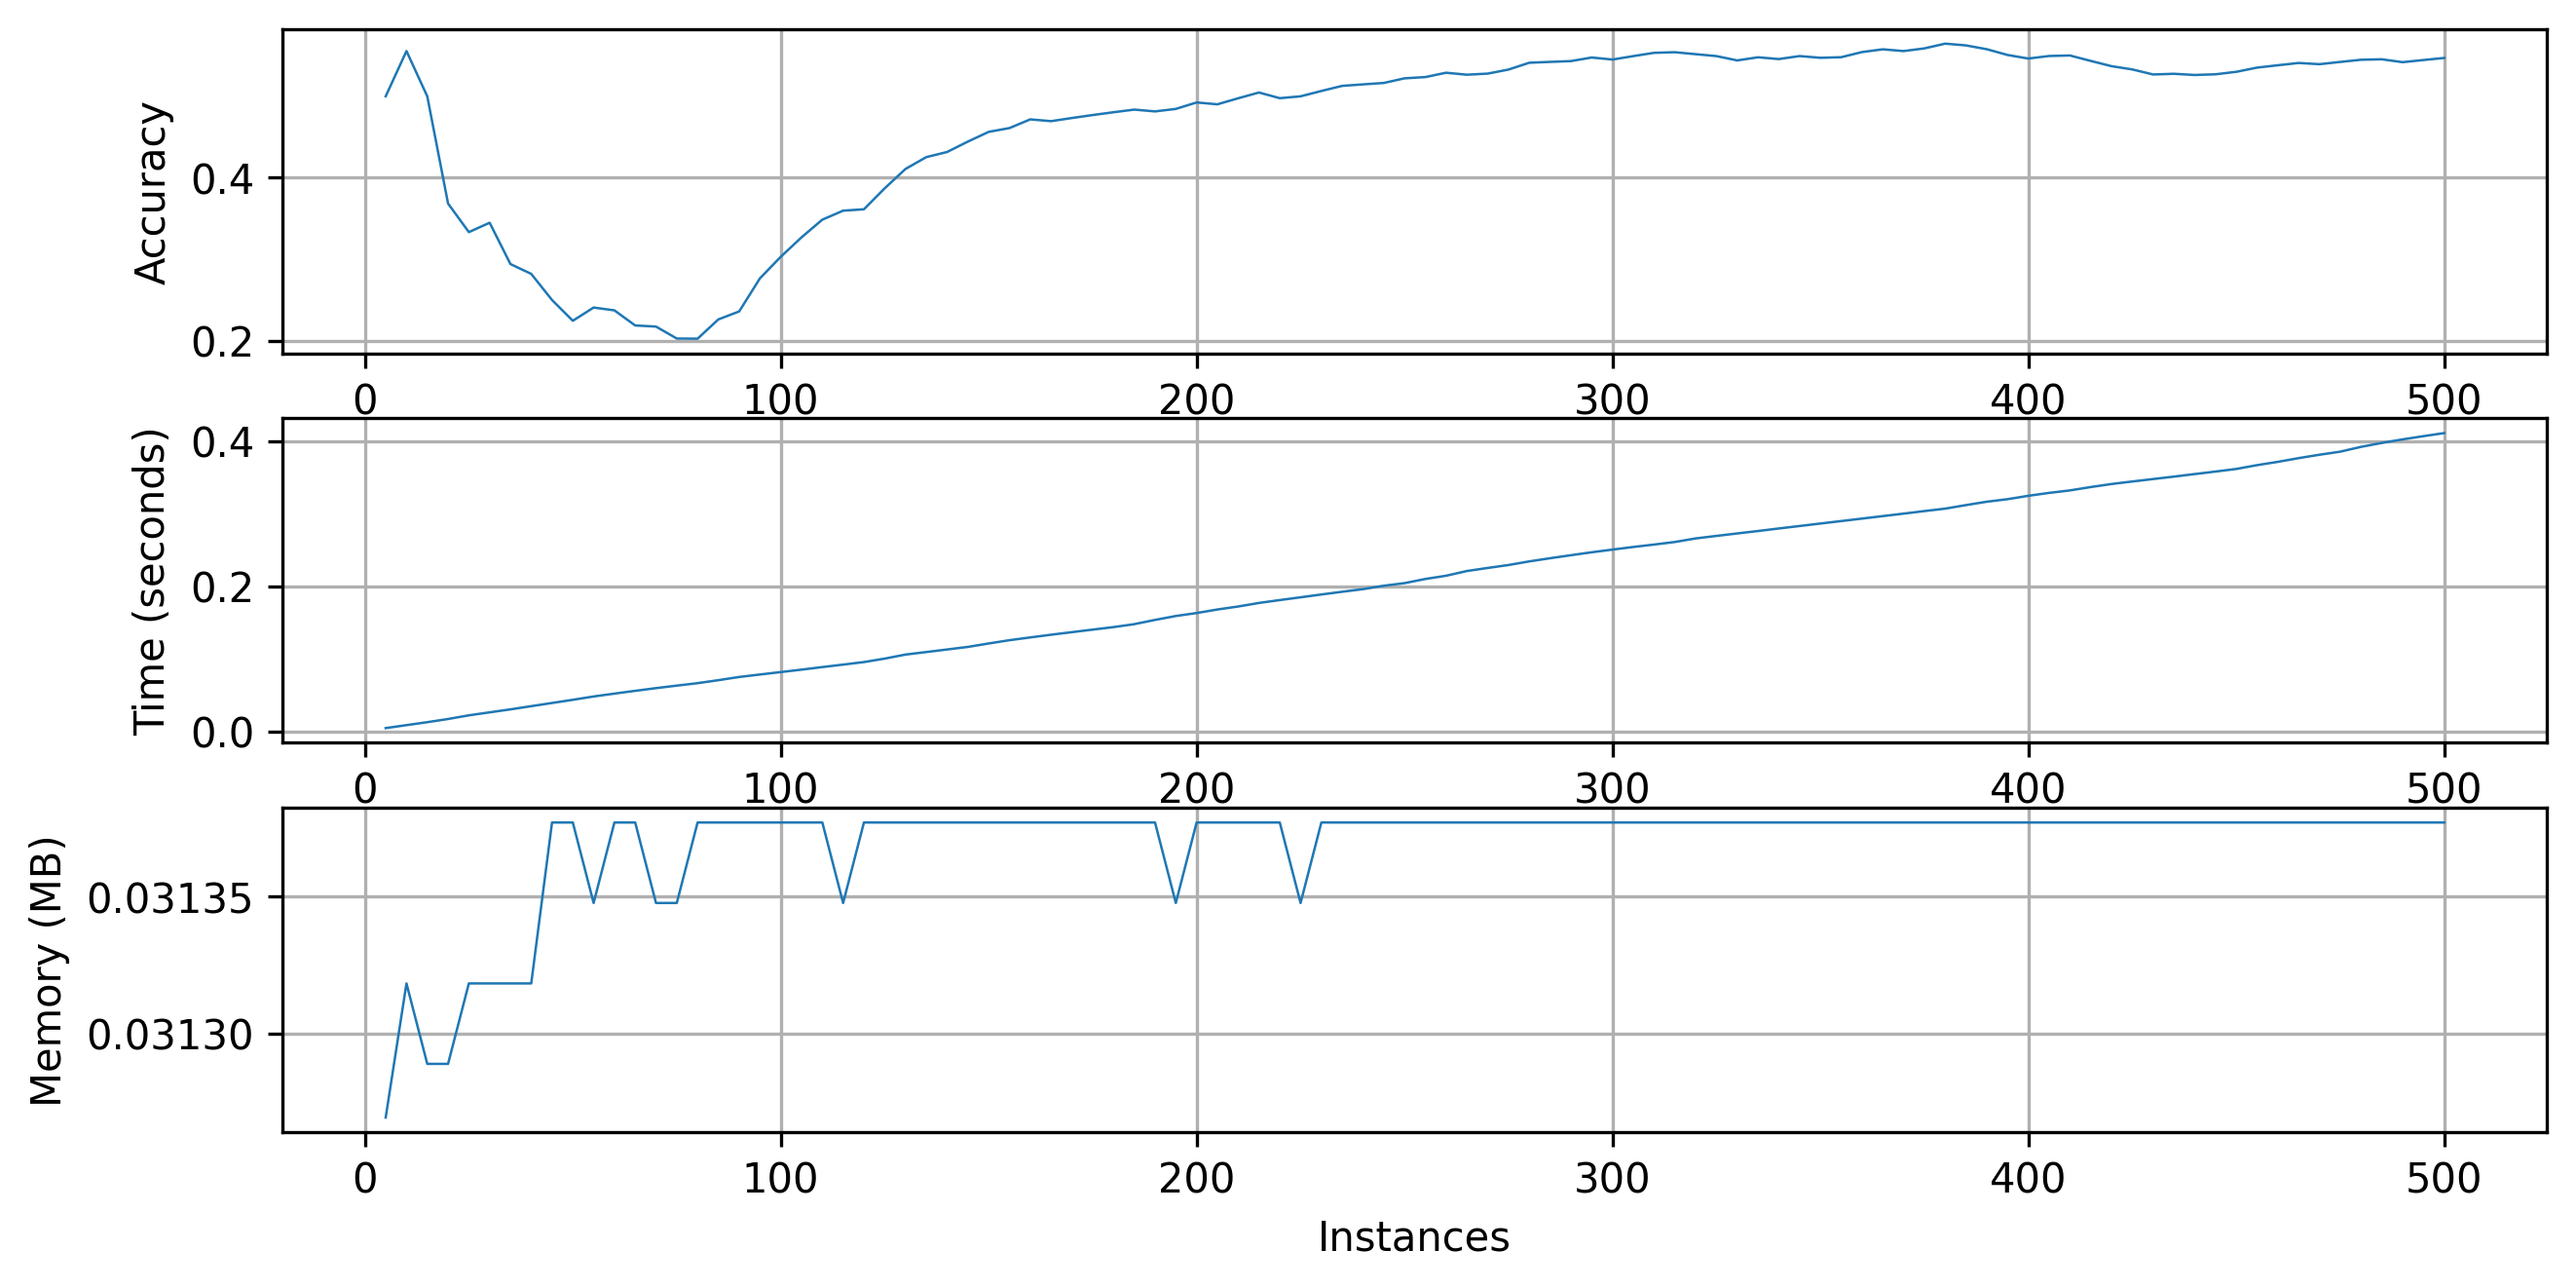

In [18]:

plt.clf()
fig, ax = plt.subplots(figsize=(10, 5), nrows=3, dpi=300 )
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

ax[0].plot(step, error, label=type(model).__name__,linewidth=.6)
ax[0].set_ylabel('Accuracy')

ax[1].plot(step, r_time, label=type(model).__name__,linewidth=.6)
ax[1].set_ylabel('Time (seconds)')

ax[2].plot(step, memory, label=type(model).__name__,linewidth=.6)
ax[2].set_ylabel('Memory (MB)')
ax[2].set_xlabel('Instances')